In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.model_selection as sk
from sklearn.utils import shuffle
import random
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,accuracy_score,roc_auc_score

C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
# get input data from Keras datasets
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
# combine x_train and x_test for later pre-processing
X = np.vstack([x_train,x_test])
y = np.append(y_train,y_test)

In [3]:
# split data by categories of 6 and 4 items
# create test2 and training dara
training_images_lab = {0:"top", 1:"trouser", 2:"pullover", 4:"coat", 5:"sandal", 9:"ankle boot"}
unseen_image_lab = {3:"dress", 7:"sneaker", 8:"bag", 6:"shirt"}
X_train = []
y_train = []
X_test = []
y_test = []
for index in range(len(y)):    
    if y[index] in training_images_lab.keys():
        X_train.append(X[index])
        y_train.append(y[index])
    else:
        X_test.append(X[index])
        y_test.append(y[index])
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test2 = np.array(X_test)
y_test2 = np.array(y_test)

In [4]:
# split training data into training and test1
X_train, X_test1, y_train, y_test1 = sk.train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# union test1 and test2
X_test3, y_test3 = np.concatenate([X_test1, X_test2]), np.concatenate([y_test1, y_test2])

In [5]:
def create_pairs(x, digit_indices):
    '''
    Positive and negative pair creation.
    x: image data
    digit_indices: location of data which arrange by categories
    '''
    pairs = []
    labels = []
    # n: minimum pairs that we can create in all category 
    n = min([len(digit_indices[d]) for d in range(len(digit_indices))]) - 1
    for d in range(len(digit_indices)):
        for i in range(n):
            # Postive Pairs
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            # Negative Pairs, randomly pick on in other category 
            inc = random.randrange(1, len(digit_indices))
            dn = (d + inc) % len(digit_indices)
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [0, 1]
    return np.array(pairs), np.array(labels)

In [6]:
# Training data - 80%
digit_indices = [np.where(y_train == i)[0] for i in list(training_images_lab.keys())]
train_x, train_y = create_pairs(X_train, digit_indices)
# Test 1 - 20% 
digit_indices = [np.where(y_test1 == i)[0] for i in list(training_images_lab.keys())]
test_x1, test_y1 = create_pairs(X_test1, digit_indices)
# Test 2 - 4 categories 
digit_indices = [np.where(y_test2 == i)[0] for i in list(unseen_image_lab.keys())]
test_x2, test_y2 = create_pairs(X_test2, digit_indices)
# Test 3 - Test1 Union Test2
all_images = list(training_images_lab.keys())+list(unseen_image_lab.keys())
digit_indices = [np.where(y_test3 == i)[0] for i in all_images]
test_x3, test_y3 = create_pairs(X_test3, digit_indices)

In [7]:
# fig, ax = plt.subplots(nrows=10, ncols=4,figsize=(40, 40))
# idx = 0
# for row in range(10):
#     idx = random.randrange(0,len(train_pairs),2)
#     ax[row,0].imshow(train_pairs[idx][0],cmap = 'gray')
#     ax[row,1].imshow(train_pairs[idx][1],cmap = 'gray')
#     idx+=1
#     ax[row,2].imshow(train_pairs[idx][0],cmap = 'gray')
#     ax[row,3].imshow(train_pairs[idx][1],cmap = 'gray')
# plt.show()

In [8]:
# add to the top of your code under import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [9]:
# Normalize train and test data
train_x = train_x.astype('float32')/255
test_x1 = test_x1.astype('float32')/255
test_x2 = test_x2.astype('float32')/255
test_x3 = test_x3.astype('float32')/255

In [10]:
# Reshape into (n, 2, 28, 28, 1)
# where n is number of examples
# img_rows and img_cols are the size of data
img_rows, img_cols = train_x.shape[2:4]
train_x = train_x.reshape(train_x.shape[0], 2 ,img_rows, img_cols, 1)
test_x1 = test_x1.reshape(test_x1.shape[0], 2, img_rows, img_cols, 1)
test_x2 = test_x2.reshape(test_x2.shape[0], 2, img_rows, img_cols, 1)
test_x3 = test_x3.reshape(test_x3.shape[0], 2, img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [11]:
# split training data into train and validation for training
train_x, val_x, train_y, val_y = sk.train_test_split(train_x, train_y, test_size=0.1, random_state=42)

In [12]:
def euclidean_distance(vects):
    '''
    compute the euclidean distance between a and b
    which a and b are ouput from two embedding layers
    the representation of embedding is highly dimensional    
    '''
    a, b = vects
    sum_square = K.sum(K.square(a - b), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    #return the shape of embedding output
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred, m = 1):
    '''
    y_pred: the distance which computed by eclidean distance
    y_true: ground truth, 1: same category, 0: different category
    m: margin which compute if a pair is in same region

    for a postive pair, we want the embedding presentation points are in a region
    for a negative pair, we want the embedding presentation points are outside the region
    
    the loss function can be split into 2 part:
    Positive pair loss1: D(Pi,Pj)^2 , where y_true = 0
    Negative pair loss2: max(0, m - D(Pi,Pj))^2  , where y_true = 1
    
    Here, we remove 1/2, cuz it's redundant
    '''
    
#   y_ture == 0
    loss1 = tf.cast(K.equal(y_true,0),dtype = 'float32') * K.square(y_pred)
#   y_ture == 1 , K.maximum:  find the element-wise maximum of tensors
    loss2 = tf.cast(K.equal(y_true,1),dtype = 'float32') * K.square(K.maximum(m - y_pred, 0))
    return K.mean(loss1 + loss2)


def accuracy(y_true, y_pred):
    '''
    Compute classification accuracy with a fixed threshold (0.5) on distance.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred > 0.5, y_true.dtype)))

In [13]:
#baseline model
def create_base_network(input_shape):
    '''
    input_shape: target image size
    Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation='relu',name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation='relu',name='block1_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation='relu',name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation='relu',name='block2_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block2_pool')(x)
    x = Flatten()(x)
    output = Dense(128, activation='relu',name = 'embeding')(x)    
    return Model(input_tensor, output)

In [14]:
# create siamese network 
def siamese_model(input_shape,cnn_base_network):
    base_network = cnn_base_network
    base_network.summary()
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    # because we re-use the same instance `base_network`,
    # the weights of the network will be shared across the two networks
    embedding_a = base_network(input_a)
    embedding_b = base_network(input_b)
    # compute the distance of embadding layer
    distance = Lambda(euclidean_distance,
                      output_shape=eucl_dist_output_shape)([embedding_a, embedding_b])

    model = Model([input_a, input_b], distance)
    model.summary()
    
    return model

In [15]:
#Plot loss and accuracy for the model
def plot_loss_accuracy(history,parameter):
    print("Tuning :"+parameter)
    loss = history.history['loss'].copy()
    val_loss= history.history['val_loss'].copy()
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss','Validation loss'])
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title("Tuning:"+parameter+" loss")
    plt.savefig('./images/'+parameter+'_loss.png', bbox_inches='tight')
    plt.show()
    plt.close()
    accuracy = history.history['accuracy'].copy()
    val_accuracy = history.history['val_accuracy'].copy()
    plt.plot(accuracy)
    plt.plot(val_accuracy)
    plt.legend(['accuracy','val_accuracy'])
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.title("Tuning :"+parameter+" accuracy")
    plt.savefig('./images/'+parameter+'_accuracy.png', bbox_inches='tight')
    plt.show()
    plt.close()

In [16]:
#Evaluate the model:test accuracy, confusion matrix and ROC curve
def evaluate_test_accuracy_roc(model,model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3):
    print("Tuning :"+model_name)
    # use trained model to predict test data
    # compute corresponding accuracy
    pred1 = model.predict([test_x1[:,0],test_x1[:,1]])
    pred2 = model.predict([test_x2[:,0],test_x2[:,1]])
    pred3 = model.predict([test_x3[:,0],test_x3[:,1]])

    te_acc1 = accuracy_score(test_y1, pred1>0.5)
    te_acc2 = accuracy_score(test_y2, pred2>0.5)
    te_acc3 = accuracy_score(test_y3, pred3>0.5)
    print('* Accuracy on test1 set: %0.2f%%' % (100 * te_acc1))
    print('* Accuracy on test2 set: %0.2f%%' % (100 * te_acc2))
    print('* Accuracy on test3 set: %0.2f%%' % (100 * te_acc3))

    model.save('./Data/model'+model_name+'.h5')
    
    # analyse precision and recall
    print(classification_report(test_y1,pred1>0.5))
    print(classification_report(test_y2,pred2>0.5))
    
    # print confusion matrix
    print("Confusion Matrix")
    print(confusion_matrix(test_y2,pred2>0.5))
    
    
    # plot ROC curve
    fpr_rf1, tpr_rf1, _ = roc_curve(test_y1, pred1)
    fpr_rf2, tpr_rf2, _ = roc_curve(test_y2, pred2)
    fpr_rf3, tpr_rf3, _ = roc_curve(test_y3, pred3)
    
    roc_index1 = roc_auc_score(test_y1, pred1)
    roc_index2 = roc_auc_score(test_y2, pred2)
    roc_index3 = roc_auc_score(test_y3, pred3)  
    
    plt.figure(figsize=(8,6))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rf1, tpr_rf1, label='test1 {:.3f}'.format(roc_index1))
    plt.plot(fpr_rf2, tpr_rf2, label='test2 {:.3f}'.format(roc_index2))
    plt.plot(fpr_rf3, tpr_rf3, label='test3 {:.3f}'.format(roc_index3))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve '+ model_name)
    plt.legend(loc='best')
    plt.savefig('./images/'+'roc_curve_'+model_name+'.png', bbox_inches='tight')
    plt.show()
    plt.close()

In [17]:
select_base_arch=create_base_network(input_shape)
model_base=siamese_model(input_shape,select_base_arch)

W1025 14:28:02.944609 17176 deprecation.py:506] From C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 8, 8, 64)          18496     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 4, 4, 64)          0     

In [18]:
model_name_base='RELU_lr_1e-4_no_dropout'

# train
epochs = 200
lr = 1e-4
adam = Adam(learning_rate=lr,decay=lr/epochs)
model_base.compile(loss= contrastive_loss, optimizer=adam, metrics=[accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
history_base = model_base.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=1024,
          epochs=epochs,
          validation_data= ([val_x[:,0],val_x[:,1]],val_y),
          callbacks=[early_stopping_callback])

W1025 14:28:03.198471 17176 deprecation.py:323] From C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 7s 113us/sample - loss: 0.2143 - accuracy: 0.6786 - val_loss: 0.1282 - val_accuracy: 0.8417
Epoch 2/200
60145/60145 [==============================] - 3s 56us/sample - loss: 0.1138 - accuracy: 0.8633 - val_loss: 0.1019 - val_accuracy: 0.8827
Epoch 3/200
60145/60145 [==============================] - 3s 56us/sample - loss: 0.0950 - accuracy: 0.8956 - val_loss: 0.0881 - val_accuracy: 0.9078
Epoch 4/200
60145/60145 [==============================] - 3s 55us/sample - loss: 0.0835 - accuracy: 0.9114 - val_loss: 0.0788 - val_accuracy: 0.9139
Epoch 5/200
60145/60145 [==============================] - 4s 58us/sample - loss: 0.0754 - accuracy: 0.9203 - val_loss: 0.0720 - val_accuracy: 0.9222
Epoch 6/200
60145/60145 [==============================] - 3s 56us/sample - loss: 0.0694 - accuracy: 0.9262 - val_loss: 0.0669 - val_accuracy: 0.9272
Epoch 7/200
60145/60145 [=========================

Epoch 55/200
60145/60145 [==============================] - 3s 56us/sample - loss: 0.0322 - accuracy: 0.9673 - val_loss: 0.0341 - val_accuracy: 0.9632
Epoch 56/200
60145/60145 [==============================] - 3s 56us/sample - loss: 0.0319 - accuracy: 0.9680 - val_loss: 0.0339 - val_accuracy: 0.9653
Epoch 57/200
60145/60145 [==============================] - 3s 56us/sample - loss: 0.0317 - accuracy: 0.9683 - val_loss: 0.0335 - val_accuracy: 0.9640
Epoch 58/200
60145/60145 [==============================] - 3s 56us/sample - loss: 0.0315 - accuracy: 0.9685 - val_loss: 0.0335 - val_accuracy: 0.9639
Epoch 59/200
60145/60145 [==============================] - 3s 56us/sample - loss: 0.0313 - accuracy: 0.9685 - val_loss: 0.0333 - val_accuracy: 0.9638
Epoch 60/200
60145/60145 [==============================] - 3s 57us/sample - loss: 0.0312 - accuracy: 0.9688 - val_loss: 0.0330 - val_accuracy: 0.9639
Epoch 61/200
60145/60145 [==============================] - 3s 56us/sample - loss: 0.0310 - ac

Epoch 163/200
60145/60145 [==============================] - 3s 57us/sample - loss: 0.0195 - accuracy: 0.9862 - val_loss: 0.0246 - val_accuracy: 0.9770
Epoch 164/200
60145/60145 [==============================] - 3s 57us/sample - loss: 0.0195 - accuracy: 0.9863 - val_loss: 0.0247 - val_accuracy: 0.9784
Epoch 165/200
60145/60145 [==============================] - 3s 57us/sample - loss: 0.0194 - accuracy: 0.9866 - val_loss: 0.0246 - val_accuracy: 0.9784
Epoch 166/200
60145/60145 [==============================] - 3s 57us/sample - loss: 0.0194 - accuracy: 0.9865 - val_loss: 0.0246 - val_accuracy: 0.9792
Epoch 167/200
60145/60145 [==============================] - 3s 57us/sample - loss: 0.0193 - accuracy: 0.9868 - val_loss: 0.0246 - val_accuracy: 0.9769
Epoch 168/200
60145/60145 [==============================] - 3s 58us/sample - loss: 0.0192 - accuracy: 0.9868 - val_loss: 0.0243 - val_accuracy: 0.9774
Epoch 169/200
60145/60145 [==============================] - 3s 57us/sample - loss: 0.01

In [19]:
plot_loss_accuracy(history_base, model_name_base)
evaluate_test_accuracy_roc(model_base, model_name_base, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

Tuning :RELU_lr_1e-4_no_dropout


Tuning :RELU_lr_1e-4_no_dropout
* Accuracy on test1 set: 96.95%
* Accuracy on test2 set: 67.01%
* Accuracy on test3 set: 83.03%
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      8238
           1       0.96      0.98      0.97      8238

    accuracy                           0.97     16476
   macro avg       0.97      0.97      0.97     16476
weighted avg       0.97      0.97      0.97     16476

              precision    recall  f1-score   support

           0       0.76      0.49      0.60     27996
           1       0.63      0.85      0.72     27996

    accuracy                           0.67     55992
   macro avg       0.69      0.67      0.66     55992
weighted avg       0.69      0.67      0.66     55992

Confusion Matrix
[[13832 14164]
 [ 4309 23687]]


### best model

In [20]:
#best model with activation function: leaky relu, dropout 20% and embedding length 64
def create_base_network_leaky_relu_64(input_shape):
    '''
    input_shape: target image size
    Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block2_pool')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    output = Dense(64, activation=tf.nn.leaky_relu,name = 'embeding')(x)    
    
    return Model(input_tensor, output)

In [21]:
select_base_arch=create_base_network_leaky_relu_64(input_shape)
model_best=siamese_model(input_shape,select_base_arch)

model_name_best='Leaky_relu_lr_1e-4_embedding_64'
# train
epochs = 200
lr = 1e-4
adam = Adam(learning_rate=lr,decay=lr/epochs)
model_best.compile(loss= contrastive_loss, optimizer=adam, metrics=[accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
history_best = model_best.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=1024,
          epochs=epochs,
          validation_data= ([val_x[:,0],val_x[:,1]],val_y),
          callbacks=[early_stopping_callback])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 8, 8, 64)          18496     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 4, 4, 64)          0   

60145/60145 [==============================] - 4s 71us/sample - loss: 0.0335 - accuracy: 0.9680 - val_loss: 0.0329 - val_accuracy: 0.9657
Epoch 89/200
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0334 - accuracy: 0.9680 - val_loss: 0.0329 - val_accuracy: 0.9636
Epoch 90/200
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0334 - accuracy: 0.9674 - val_loss: 0.0332 - val_accuracy: 0.9638
Epoch 91/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0333 - accuracy: 0.9679 - val_loss: 0.0326 - val_accuracy: 0.9642
Epoch 92/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0331 - accuracy: 0.9680 - val_loss: 0.0327 - val_accuracy: 0.9651
Epoch 93/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0331 - accuracy: 0.9685 - val_loss: 0.0325 - val_accuracy: 0.9657
Epoch 94/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0328 - accuracy: 0.969

60145/60145 [==============================] - 4s 70us/sample - loss: 0.0293 - accuracy: 0.9745 - val_loss: 0.0298 - val_accuracy: 0.9712
Epoch 143/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0292 - accuracy: 0.9744 - val_loss: 0.0297 - val_accuracy: 0.9707
Epoch 144/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0290 - accuracy: 0.9751 - val_loss: 0.0296 - val_accuracy: 0.9719
Epoch 145/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0290 - accuracy: 0.9750 - val_loss: 0.0293 - val_accuracy: 0.9735
Epoch 146/200
60145/60145 [==============================] - 4s 71us/sample - loss: 0.0290 - accuracy: 0.9752 - val_loss: 0.0294 - val_accuracy: 0.9725
Epoch 147/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0287 - accuracy: 0.9759 - val_loss: 0.0295 - val_accuracy: 0.9719
Epoch 148/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0288 - accuracy:

Epoch 196/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0265 - accuracy: 0.9796 - val_loss: 0.0278 - val_accuracy: 0.9739
Epoch 197/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0266 - accuracy: 0.9795 - val_loss: 0.0277 - val_accuracy: 0.9757
Epoch 198/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0266 - accuracy: 0.9789 - val_loss: 0.0276 - val_accuracy: 0.9754
Epoch 199/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0267 - accuracy: 0.9788 - val_loss: 0.0276 - val_accuracy: 0.9757
Epoch 200/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0265 - accuracy: 0.9791 - val_loss: 0.0278 - val_accuracy: 0.9751


Tuning :Leaky_relu_lr_1e-4_embedding_64


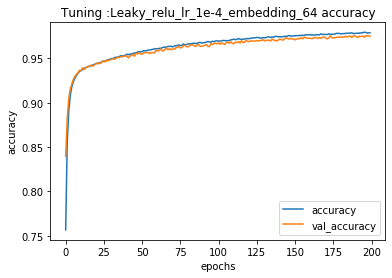

Tuning :Leaky_relu_lr_1e-4_embedding_64
* Accuracy on test1 set: 96.91%
* Accuracy on test2 set: 70.62%
* Accuracy on test3 set: 84.37%
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      8238
           1       0.97      0.97      0.97      8238

    accuracy                           0.97     16476
   macro avg       0.97      0.97      0.97     16476
weighted avg       0.97      0.97      0.97     16476

              precision    recall  f1-score   support

           0       0.74      0.63      0.68     27996
           1       0.68      0.78      0.73     27996

    accuracy                           0.71     55992
   macro avg       0.71      0.71      0.70     55992
weighted avg       0.71      0.71      0.70     55992

Confusion Matrix
[[17580 10416]
 [ 6034 21962]]


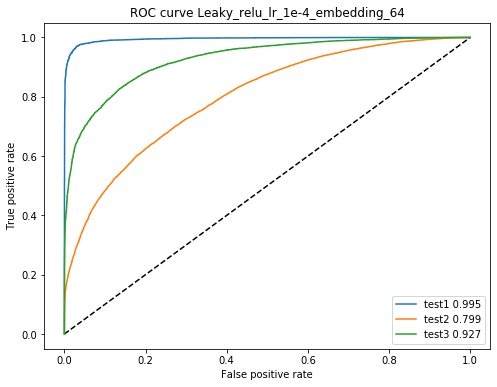

In [22]:
plot_loss_accuracy(history_best, model_name_best)
evaluate_test_accuracy_roc(model_best, model_name_best, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [23]:
#Evaluate the model:test accuracy, confusion matrix and ROC curve
def conf_matrix(model,model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3):
    print("Tuning :"+model_name)
    # use trained model to predict test data
    # compute corresponding accuracy
    pred1 = model.predict([test_x1[:,0],test_x1[:,1]])
    pred2 = model.predict([test_x2[:,0],test_x2[:,1]])
    pred3 = model.predict([test_x3[:,0],test_x3[:,1]])

    te_acc1 = accuracy_score(test_y1, pred1>0.5)
    te_acc2 = accuracy_score(test_y2, pred2>0.5)
    te_acc3 = accuracy_score(test_y3, pred3>0.5)

    # print confusion matrix
    print("Confusion Matrix")
    print(confusion_matrix(test_y2,pred2>0.5))
    
    return pred2

In [26]:
#best model with activation function: leaky relu, dropout 20% and embedding length 64
def create_base_network_leaky_relu_32(input_shape):
    '''
    input_shape: target image size
    Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block2_pool')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    output = Dense(64, activation=tf.nn.leaky_relu,name = 'embeding')(x)    
    
    return Model(input_tensor, output)

In [27]:
select_base_arch=create_base_network_leaky_relu_32(input_shape)
model_check=siamese_model(input_shape,select_base_arch)

model_name_check='Leaky_relu_lr_1e-4_embedding_32'
# train
epochs = 200
lr = 1e-4
adam = Adam(learning_rate=lr,decay=lr/epochs)
model_check.compile(loss= contrastive_loss, optimizer=adam, metrics=[accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
history_check = model_check.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=1024,
          epochs=epochs,
          validation_data= ([val_x[:,0],val_x[:,1]],val_y),
          callbacks=[early_stopping_callback])

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 8, 8, 64)          18496     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 4, 4, 64)          0   

60145/60145 [==============================] - 4s 70us/sample - loss: 0.0325 - accuracy: 0.9706 - val_loss: 0.0318 - val_accuracy: 0.9665
Epoch 89/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0322 - accuracy: 0.9705 - val_loss: 0.0317 - val_accuracy: 0.9678
Epoch 90/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0322 - accuracy: 0.9707 - val_loss: 0.0318 - val_accuracy: 0.9672
Epoch 91/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0320 - accuracy: 0.9715 - val_loss: 0.0317 - val_accuracy: 0.9666
Epoch 92/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0318 - accuracy: 0.9714 - val_loss: 0.0316 - val_accuracy: 0.9696
Epoch 93/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0318 - accuracy: 0.9715 - val_loss: 0.0314 - val_accuracy: 0.9670
Epoch 94/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0315 - accuracy: 0.972

60145/60145 [==============================] - 4s 70us/sample - loss: 0.0277 - accuracy: 0.9784 - val_loss: 0.0282 - val_accuracy: 0.9742
Epoch 143/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0276 - accuracy: 0.9789 - val_loss: 0.0282 - val_accuracy: 0.9741
Epoch 144/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0275 - accuracy: 0.9790 - val_loss: 0.0284 - val_accuracy: 0.9743
Epoch 145/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0276 - accuracy: 0.9785 - val_loss: 0.0283 - val_accuracy: 0.9741
Epoch 146/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0275 - accuracy: 0.9788 - val_loss: 0.0280 - val_accuracy: 0.9745
Epoch 147/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0274 - accuracy: 0.9786 - val_loss: 0.0282 - val_accuracy: 0.9745
Epoch 148/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0275 - accuracy:

Epoch 196/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0251 - accuracy: 0.9824 - val_loss: 0.0261 - val_accuracy: 0.9770
Epoch 197/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0250 - accuracy: 0.9831 - val_loss: 0.0262 - val_accuracy: 0.9765
Epoch 198/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0250 - accuracy: 0.9829 - val_loss: 0.0261 - val_accuracy: 0.9782
Epoch 199/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0248 - accuracy: 0.9832 - val_loss: 0.0261 - val_accuracy: 0.9768
Epoch 200/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.0248 - accuracy: 0.9835 - val_loss: 0.0262 - val_accuracy: 0.9765


Tuning :Leaky_relu_lr_1e-4_embedding_32


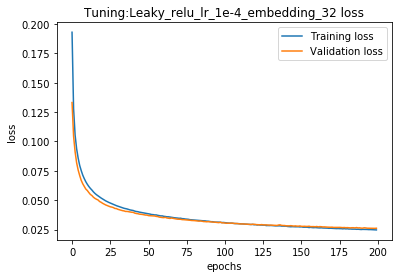

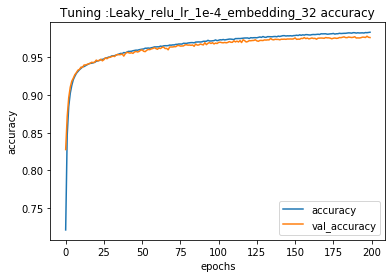

Tuning :Leaky_relu_lr_1e-4_embedding_32
* Accuracy on test1 set: 96.89%
* Accuracy on test2 set: 71.34%
* Accuracy on test3 set: 84.84%
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      8238
           1       0.97      0.97      0.97      8238

    accuracy                           0.97     16476
   macro avg       0.97      0.97      0.97     16476
weighted avg       0.97      0.97      0.97     16476

              precision    recall  f1-score   support

           0       0.74      0.65      0.69     27996
           1       0.69      0.78      0.73     27996

    accuracy                           0.71     55992
   macro avg       0.72      0.71      0.71     55992
weighted avg       0.72      0.71      0.71     55992

Confusion Matrix
[[18233  9763]
 [ 6287 21709]]


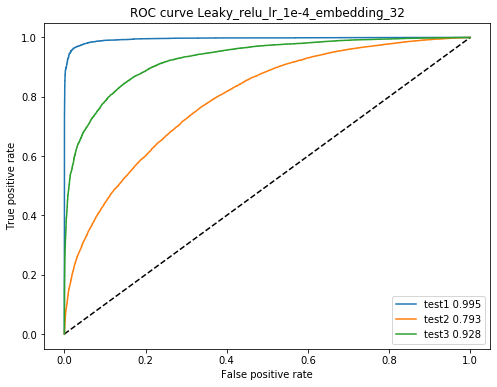

In [28]:
plot_loss_accuracy(history_check, model_name_check)
evaluate_test_accuracy_roc(model_check, model_name_check, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [142]:
pred2=conf_matrix(model_best, model_name_best, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

Tuning :Leaky_relu_lr_1e-4_embedding_64
Confusion Matrix
[[17580 10416]
 [ 6034 21962]]


Text(0.5, 1, 'Confusion Matrix')

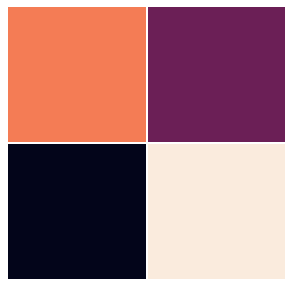

In [145]:
cm=confusion_matrix(test_y2,pred2>0.5)
text = np.asarray([['TN', 'FP'], ['FN' ,'TP']])
labels = (np.asarray(["{0} {1:.2f}".format(text,cm) for text, cm in zip(text.flatten(), cm.flatten())])).reshape(2,2)

fig, ax = plt.subplots(figsize=(5, 5))
heat_map = sns.heatmap(cm, annot=labels, fmt='',cbar=False, linewidths=1)
ax.set(yticks=[0, 2], 
       yticklabels=index)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
plt.xticks([])
plt.yticks([])
ax.set_title('Confusion Matrix')